In [21]:
import numpy as np
import pandas as pd
from scipy import constants
from scipy.optimize import minimize
from scipy.stats import t
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('trouton.csv')
df.head()

,Class,Substance,T_B (K),H_v (kcal/mol)
0,Perfect liquids,Ar,87.29,1.558
1,Perfect liquids,Kr,119.93,2.158
2,Perfect liquids,Xe,165.10,3.021
3,Perfect liquids,Rn,211.00,3.920
4,Perfect liquids,N2,77.34,1.333


In [25]:
def objective(a, b):
    """
    Computes the sum of squared residuals for a linear regression model.

    Parameters:
        a: slope
        b: intercept

    Returns:
        Residual sum of squares
    """
    pred = a*df['T_B (K)'] + b
    sse = np.sum((df['H_v (kcal/mol)'] - pred)**2)
    return sse

In [17]:
slope, intercept = minimize(
    lambda arr: objective(arr[0], arr[1]), 
    (0.02, 0), 
    method='Nelder-Mead', 
    tol=1e-6
)['x']

In [18]:
slope_JmolK = slope * 1000 * constants.calorie
intercept_kJmol = intercept * constants.calorie

## Compare with linear regression

In [16]:
def ols_slope(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    return numerator / denominator

def ols_intercept(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope = ols_slope(x, y)
    return y_mean - slope * x_mean

def ols(x, y):
    slope = ols_slope(x, y)
    intercept = ols_intercept(x, y)
    return slope, intercept

# Calculate the sum of the squared residuals
def sse(residuals):
    return np.sum(residuals ** 2)

# Calculate the variance of the residuals
def variance(residuals):
    return sse(residuals) / (len(residuals) - 2)

# Calculate the standard error of the slope
def se_slope(x, residuals):
    # numerator
    numerator = variance(residuals)
    # denominator
    x_mean = np.mean(x)
    denominator = np.sum((x - x_mean) ** 2)
    return np.sqrt(numerator / denominator)

def se_intercept(x, residuals):
    x_mean = np.mean(x)
    denominator = np.sum((x - x_mean) ** 2)
    return np.sqrt(variance(residuals)*(1/len(x) + x_mean**2 / denominator))

# Calculate the confidence interval
def confidence_interval_slope(x, residuals, confidence_level):
    # Calculate the standard error of the slope
    se = se_slope(x, residuals)

    # Calculate the critical t-value
    n_data_points = len(x)
    df = n_data_points - 2  # degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha/2, df)

    # Calculate the confidence interval
    return critical_t_value * se

# Calculate the confidence interval for the intercept
def confidence_interval_intercept(x, residuals, confidence_level):
    # Calculate the standard error of the intercept
    se = se_intercept(x, residuals)

    # Calculate the critical t-value
    n_data_points = len(x)
    df = n_data_points - 2  # degrees of freedom
    alpha = 1 - confidence_level
    critical_t_value = t.ppf(1 - alpha/2, df)

    # Calculate the confidence interval
    return critical_t_value * se

# linear regression
print("Performing linear regression")
slope, intercept = ols(df['T_B (K)'], df['H_v (kcal/mol)'])
slope_JmolK_lr = slope * 1000 * constants.calorie
intercept_kJmol_lr = intercept * constants.calorie

Performing linear regression


In [20]:
print(f"Slope (J/mol K): optimization {slope_JmolK:.2f}, regression {slope_JmolK_lr:.2f}")
print(f"Intercept (kJ/mol): optimization {intercept_kJmol:.2f}, regression {intercept_kJmol_lr:.2f}")

Slope (J/mol K): optimization 103.85, regression 103.85
Intercept (kJ/mol): optimization -4.84, regression -4.84


In [22]:
df['H_v (kJ/mol)'] = df['H_v (kcal/mol)'].apply(lambda x: x*constants.calorie)

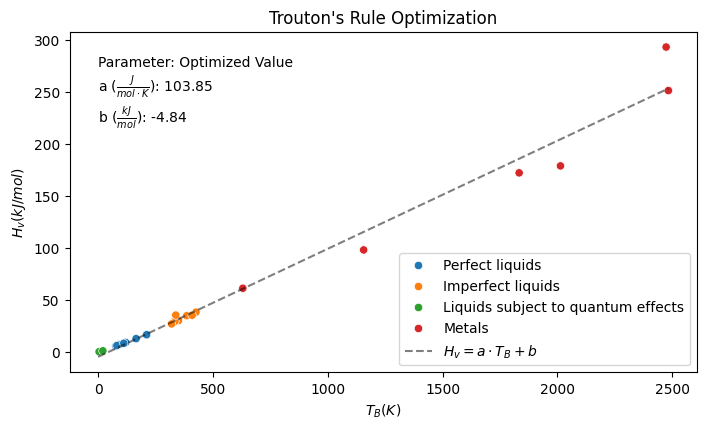

In [24]:
fig, ax = plt.subplots(figsize=(7, 4))
fig.tight_layout()

# plot with different colors by class
sns.scatterplot(df, ax=ax, x='T_B (K)', y='H_v (kJ/mol)', hue='Class')

# plot fitted line
x = np.linspace(0, df['T_B (K)'].max(), 2)
ax.plot(x, 
    slope_JmolK/1000*x+intercept_kJmol, # make sure units match 
    '--', 
    label=f"$H_v = a\\cdot T_B + b$",
    alpha=0.5,
    color='black'
)

# annotate CI
ax.text(0, 200, f"""Parameter: Optimized Value
a ($\\frac{{J}}{{mol\\cdot K}}$): {slope_JmolK:.2f}
b ($\\frac{{kJ}}{{mol}}$): {intercept_kJmol:.2f}
""")
ax.set_xlabel("$T_B (K)$")
ax.set_ylabel("$H_v (kJ/mol)$")
ax.set_title("Trouton's Rule Optimization")
ax.legend()
fig.savefig('homework-3-2/trouton.png', dpi=200, bbox_inches='tight')

## Interpretation

Both the slope and intercept from the optimization have the same value as their linear regression counterparts (at least to 2 decimal places).<br>
The optimization-based approach works well in this case, and would be preferred if we have a more complex model that does not have an analytical solution for the best fit. However, if the objective function has more than one local minima, optimization might produce a result that is not globally optimized and we would have difficulty detecting that. What's more, we cannot obtain confidence intervals from optimization alone.<br>
On the other hand, linear regression guarantees a best fit solution and also gives the confidence intervals for the best fit parameters. However, not every regression has an analytical best solution, so this approach is model-specific and cannot be generalized.